In [1]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras import models, layers, regularizers

Using TensorFlow backend.


In [22]:
data = pd.read_csv("Gillam_fin.csv").dropna()
data = data.drop("Unnamed: 0", axis = 1)
pd.DataFrame.head(data)

,id,transcript_id,gloss,part_of_speech,Impaired,Age,Gender
0,3772732,9573,and she asked um where do you wanna go,coord pro0sub v adv0int mod pro0per v v,1,10,0
1,3772777,9573,and the kids I guess answered Mcdonalds,coord det0art n v n0prop,1,10,0
2,3772812,9573,and so they went to Mcdonalds,coord co pro0sub v prep n0prop,1,10,0
3,3772852,9573,and Lisa couldn't make up her mind,coord n0prop mod v prep det0poss n,1,10,0
4,3772884,9573,and um she was deciding between a Big_Mac or a...,coord pro0sub aux part prep det0art n0prop coo...,1,10,0


In [23]:
# Split train, val, test
train, test = train_test_split(data, test_size=0.15, random_state=1234, shuffle = True)

# Process POS tags as X variable
str_train = list(train["part_of_speech"])
str_test = list(test["part_of_speech"])

Imp_train = train["Impaired"]
Imp_test = test["Impaired"]

Age_train = train["Age"]
Age_test = test["Age"]

In [24]:
# Vectorize tags
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(encoding = 'utf-8', ngram_range=(2,3))
X_train = vectorizer.fit_transform(str_train)
X_test = vectorizer.transform(str_test)
pos_vocab = vectorizer.vocabulary_

In [25]:
print(pos_vocab)

{u'neg adv adv': 4861, u'inf pro0indef conj': 4011, u'n0prop mod pro0per': 4658, u'adv adj conj': 331, u'part prep adv': 5155, u'co mod adv': 1470, u'pro0sub pro0rel pro0obj': 7449, u'pro0sub det0art det0art': 7117, u'adv prep pro0sub': 675, u'part co prep': 5007, u'pro0per pro0obj adv': 6689, u'pro0dem pro0rel pro0sub': 5934, u'mod prep pro0indef': 4267, u'part prep adj': 5154, u'aux part pro0obj': 1256, u'mod part pro0sub': 4254, u'adv0tem pro0per det0num': 1095, u'det0num prep n0prop': 3414, u'qn qn aux': 7701, u'pro0int det0poss co': 6189, u'pro0sub adv mod': 6970, u'coord pro0exist det0art': 2253, u'det0poss adj inf': 3480, u'adv0tem pro0sub aux': 1112, u'coord coord part': 2016, u'cop adj post': 2413, u'pro0exist coord': 5954, u'mod det0art det0art': 4181, u'n0prop cop pro0rel': 4580, u'inf qn pro0sub': 4090, u'pro0rel det0art adj': 6803, u'pro0sub det0art inf': 7120, u'prep pro0dem prep': 5624, u'conj det0num prep': 1713, u'det0art aux neg': 2741, u'part prep adv0int': 5156, u'd

In [26]:
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet

# Create a list of models
models = []
models_mse = []
models_auc = []

err_lst = ['neg_mean_squared_error', 'roc_auc']

def get_err(model, X, y):
    """
    Define a function that returns MSE and AUC
    """
    mse = np.mean(-cross_val_score(model, X, y, scoring=err_lst[0], cv = 5))
    auc = np.mean(cross_val_score(model, X, y, scoring=err_lst[1], cv = 5))
    return mse, auc

# Analysis 1: Impaired ~ POS vectors

In [27]:
## Logistic Regression
# Training
mse_lst = []
C_lst = np.arange(0.1, 1, 0.1)
for c in C_lst:
    LR = LogisticRegression(
        class_weight = {0: 3.380773819669337, 1: 1},
        solver = 'liblinear',
        penalty = 'l1',
        C = c)
    LR.fit(X_train, Imp_train)
    mse = np.mean(-cross_val_score(LR, X_train, Imp_train, cv=KFold(5), scoring=err_lst[0]))
    mse_lst.append(mse)
        
mse = min(mse_lst)
opt_C = C_lst[np.argmin(mse_lst)]
print("Best hyperparameter for Logistic Regression penalty is {}".format([{'C' : opt_C}]))

# Evaluation
LR_opt = LogisticRegression(
        class_weight = {0: 3.380773819669337, 1: 1},
        solver = 'liblinear',
        penalty = 'l1',
        C = opt_C)
LR_opt.fit(X_train, Imp_train)
mse, auc = get_err(LR_opt, X_train, Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(LR_opt)
models_mse.append(mse)
models_auc.append(auc)

Best hyperparameter for Logistic Regression penalty is [{'C': 0.1}]
MSE: 0.230148
AUC: 0.588158


In [28]:
## Naive-Bayes
# Training
NB = MultinomialNB()
NB.fit(X_train, Imp_train)

# Evaluation
mse, auc = get_err(NB, X_train, Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(NB)
models_mse.append(mse)
models_auc.append(auc)

MSE: 0.235359
AUC: 0.620136


In [29]:
## SVM Classifier
# Training
SVC = LinearSVC()
SVC.fit(X_train, Imp_train)

# Evaluation
mse, auc = get_err(SVC, X_train, Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(SVC)
models_mse.append(mse)
models_auc.append(auc)

MSE: 0.243438
AUC: 0.628875


In [30]:
## Ridge
# Tuning
alphas = np.arange(0,10,1)
mse_lst = []
for a in alphas:
    ridge = Ridge(alpha = a, solver = 'lsqr')
    ridge.fit(X_train, Imp_train)
    mse = np.mean(-cross_val_score(ridge, X_train, Imp_train, cv=KFold(5), scoring=err_lst[0]))
    mse_lst.append(mse)
        
mse = min(mse_lst)
opt_a = alphas[np.argmin(mse_lst)]
print("Best hyperparameter for Ridge penalty is {}".format([{'alpha' : opt_a}]))
print(mse)

# Evaluation
ridge_opt = Ridge(alpha = opt_a, solver = 'lsqr')
mse, auc = get_err(ridge_opt, X_train, Imp_train)

print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(ridge_opt)
models_mse.append(mse)
models_auc.append(auc)

/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:332: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


Best hyperparameter for Ridge penalty is [{'alpha': 8}]
0.16908700281006486
MSE: 0.169087
AUC: 0.644405


In [31]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

## Random Forest

rf = RandomForestClassifier(
        n_estimators= 100,random_state= 1,
        criterion= 'gini',
        max_depth= 5,
        min_weight_fraction_leaf= 0,
        bootstrap= True)
rf.fit(X_train,Imp_train)
mse, auc = get_err(rf, X_train, Imp_train)
print("MSE: {:.6f}".format(mse))
print("AUC: {:.6f}".format(auc))

models.append(rf)
models_mse.append(mse)
models_auc.append(auc)

MSE: 0.230148
AUC: 0.627530


In [33]:
# Models Summary
models_col = ['Logistic Regression', 'Naive-Bayes', "LinearSVC",
              'Ridge', 'Random Forest']
models_report = pd.DataFrame([models_col, models_mse, models_auc]).T
models_report = models_report.rename({0 : "Models", 1 : "Error Rates", 2 : "AUC"}, axis = 1)
models_report = models_report.sort_values("Error Rates")

Text(0.5,1,'Error Rates for Models')

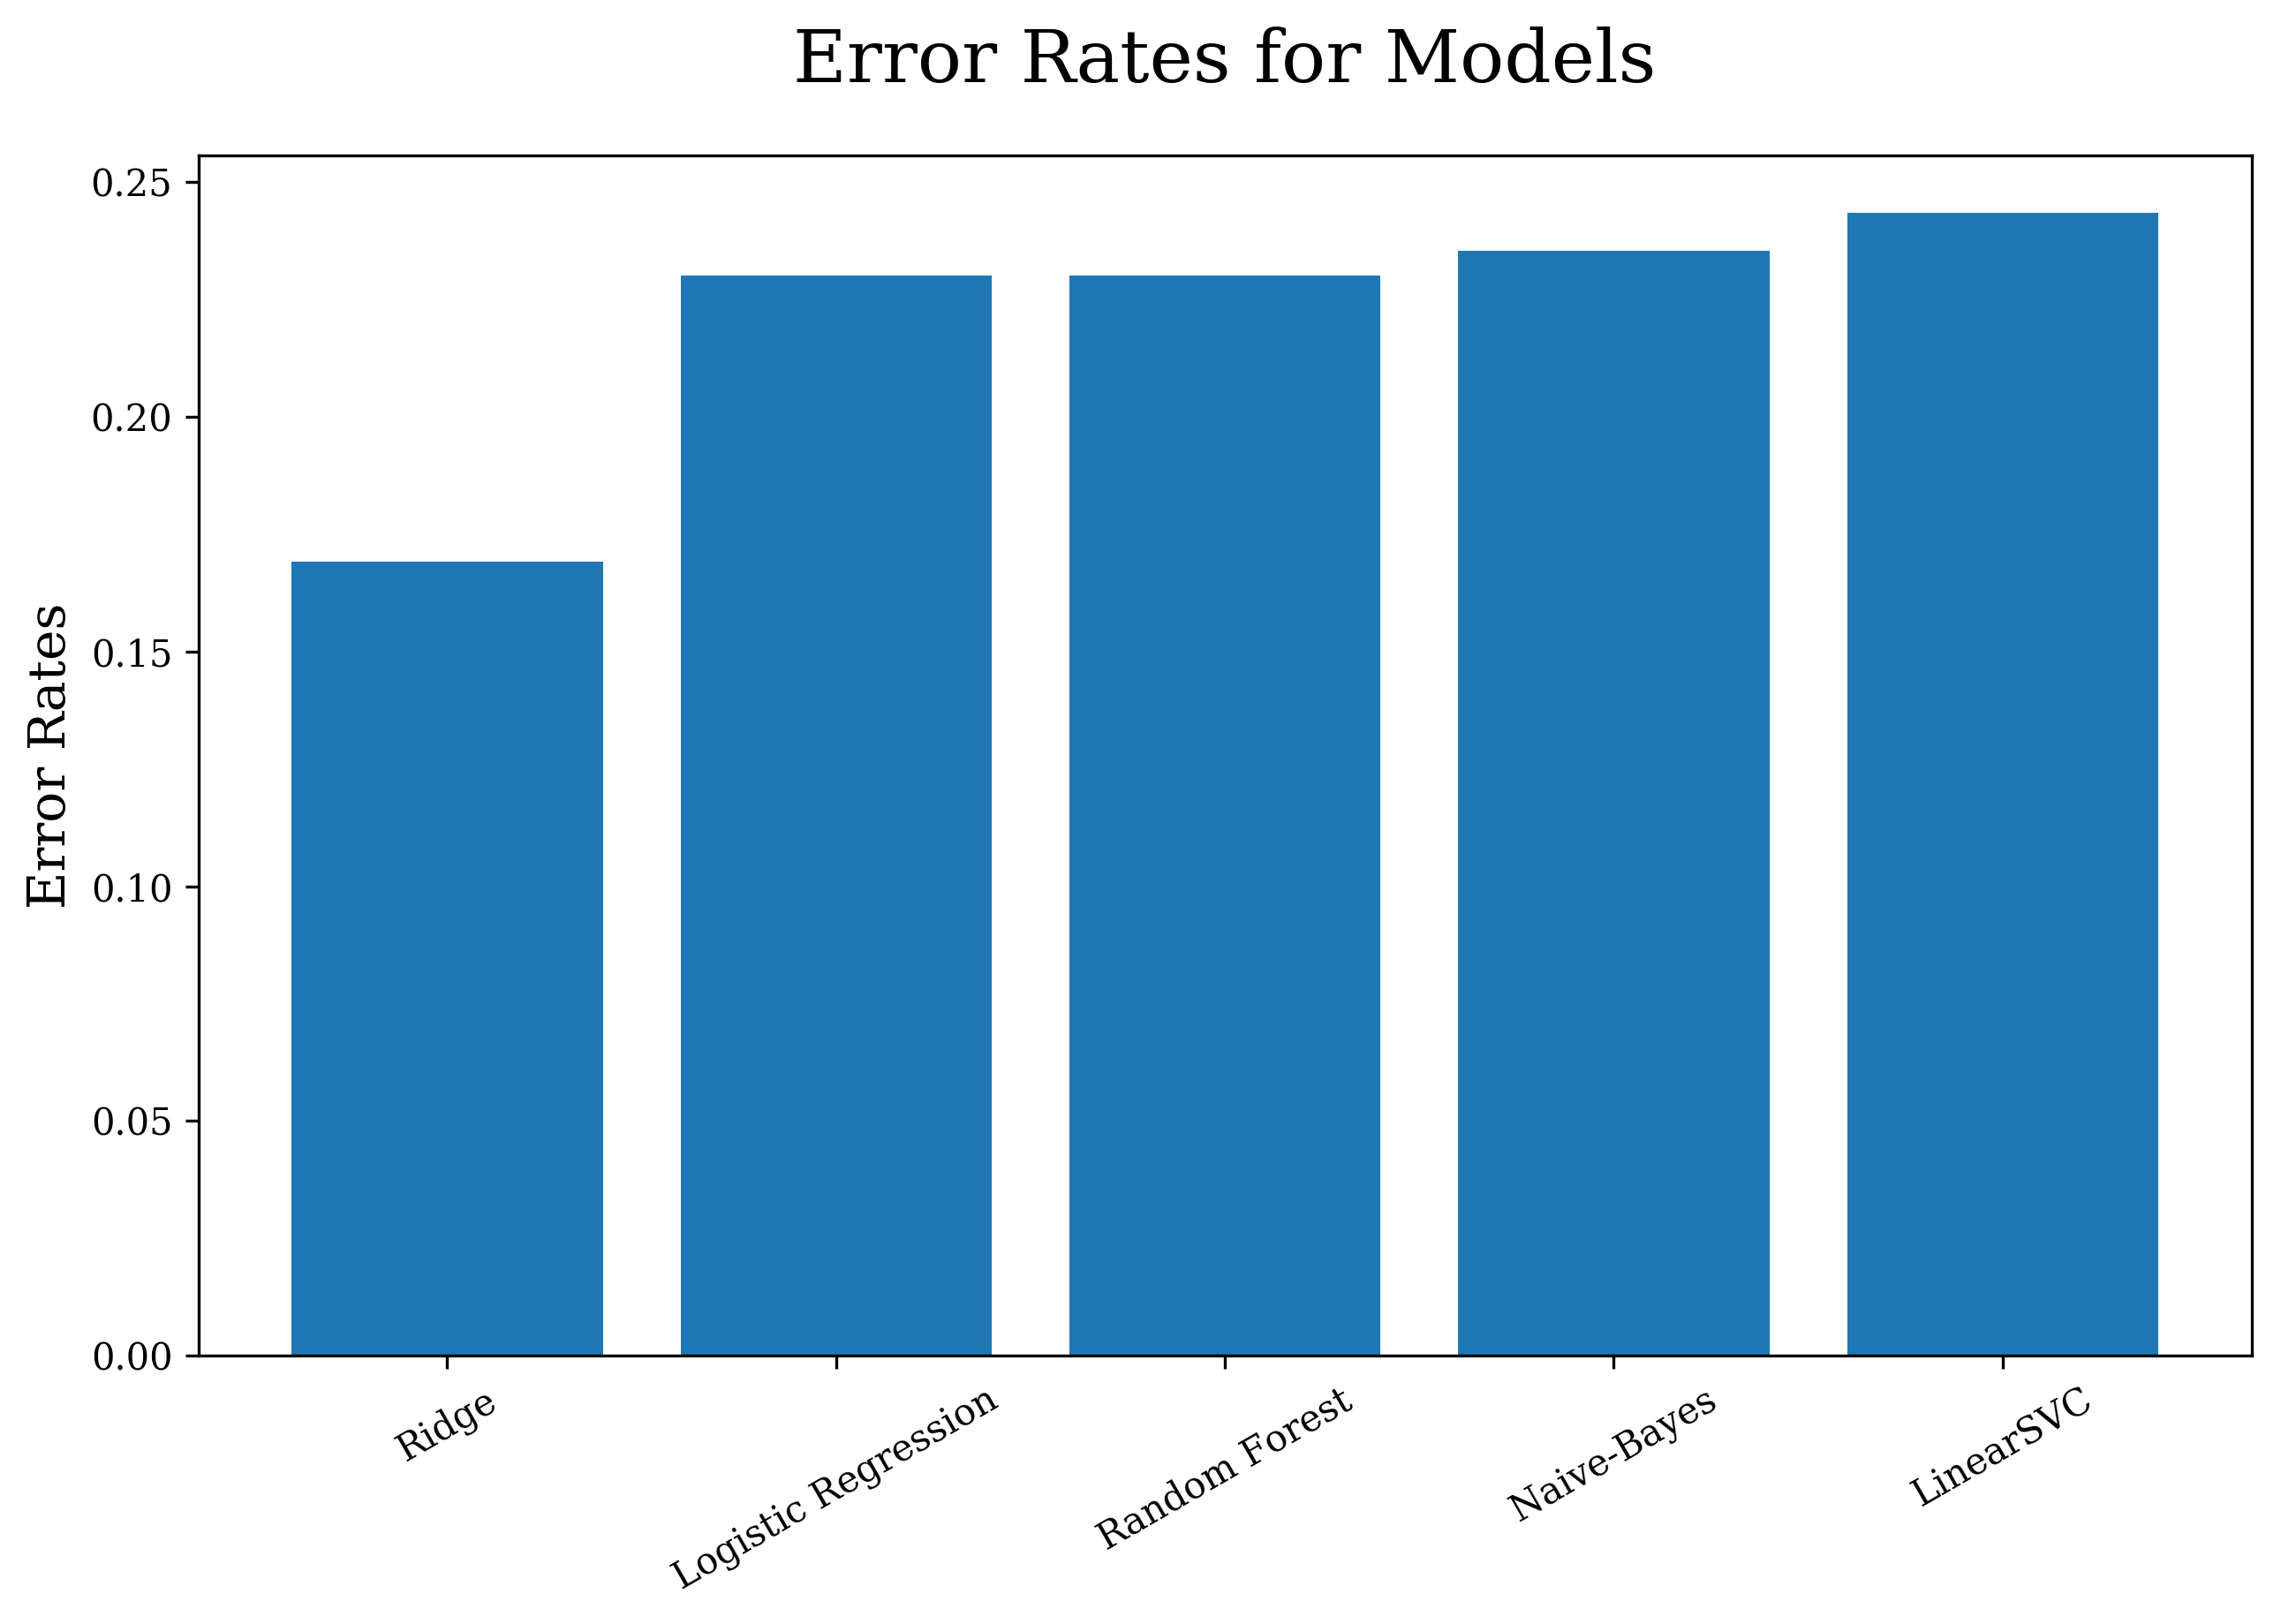

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['axes.titlepad'] = 20

plt.figure(figsize = (10,6), dpi = 300)
plt.bar(models_report["Models"], models_report["Error Rates"])
plt.xticks(rotation = 30)
plt.ylabel("Error Rates", fontsize = 14)
plt.title('Error Rates for Models', fontsize = 20)

In [35]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation

best_model = models[3].fit(X_train, Imp_train)

# # calculate the feature importance
model = InMemoryModel(best_model.predict, examples = X_train.toarray())
interpreter = Interpretation(X_train.toarray())
importance = interpreter.feature_importance.feature_importance(model)

[7710/7710] features ████████████████████ Time elapsed: 77171 seconds

In [36]:
feature_idx = list(importance[-50:].index)
features = []
for idx in feature_idx:
    features.append(pos_vocab.keys()[pos_vocab.values().index(idx)])

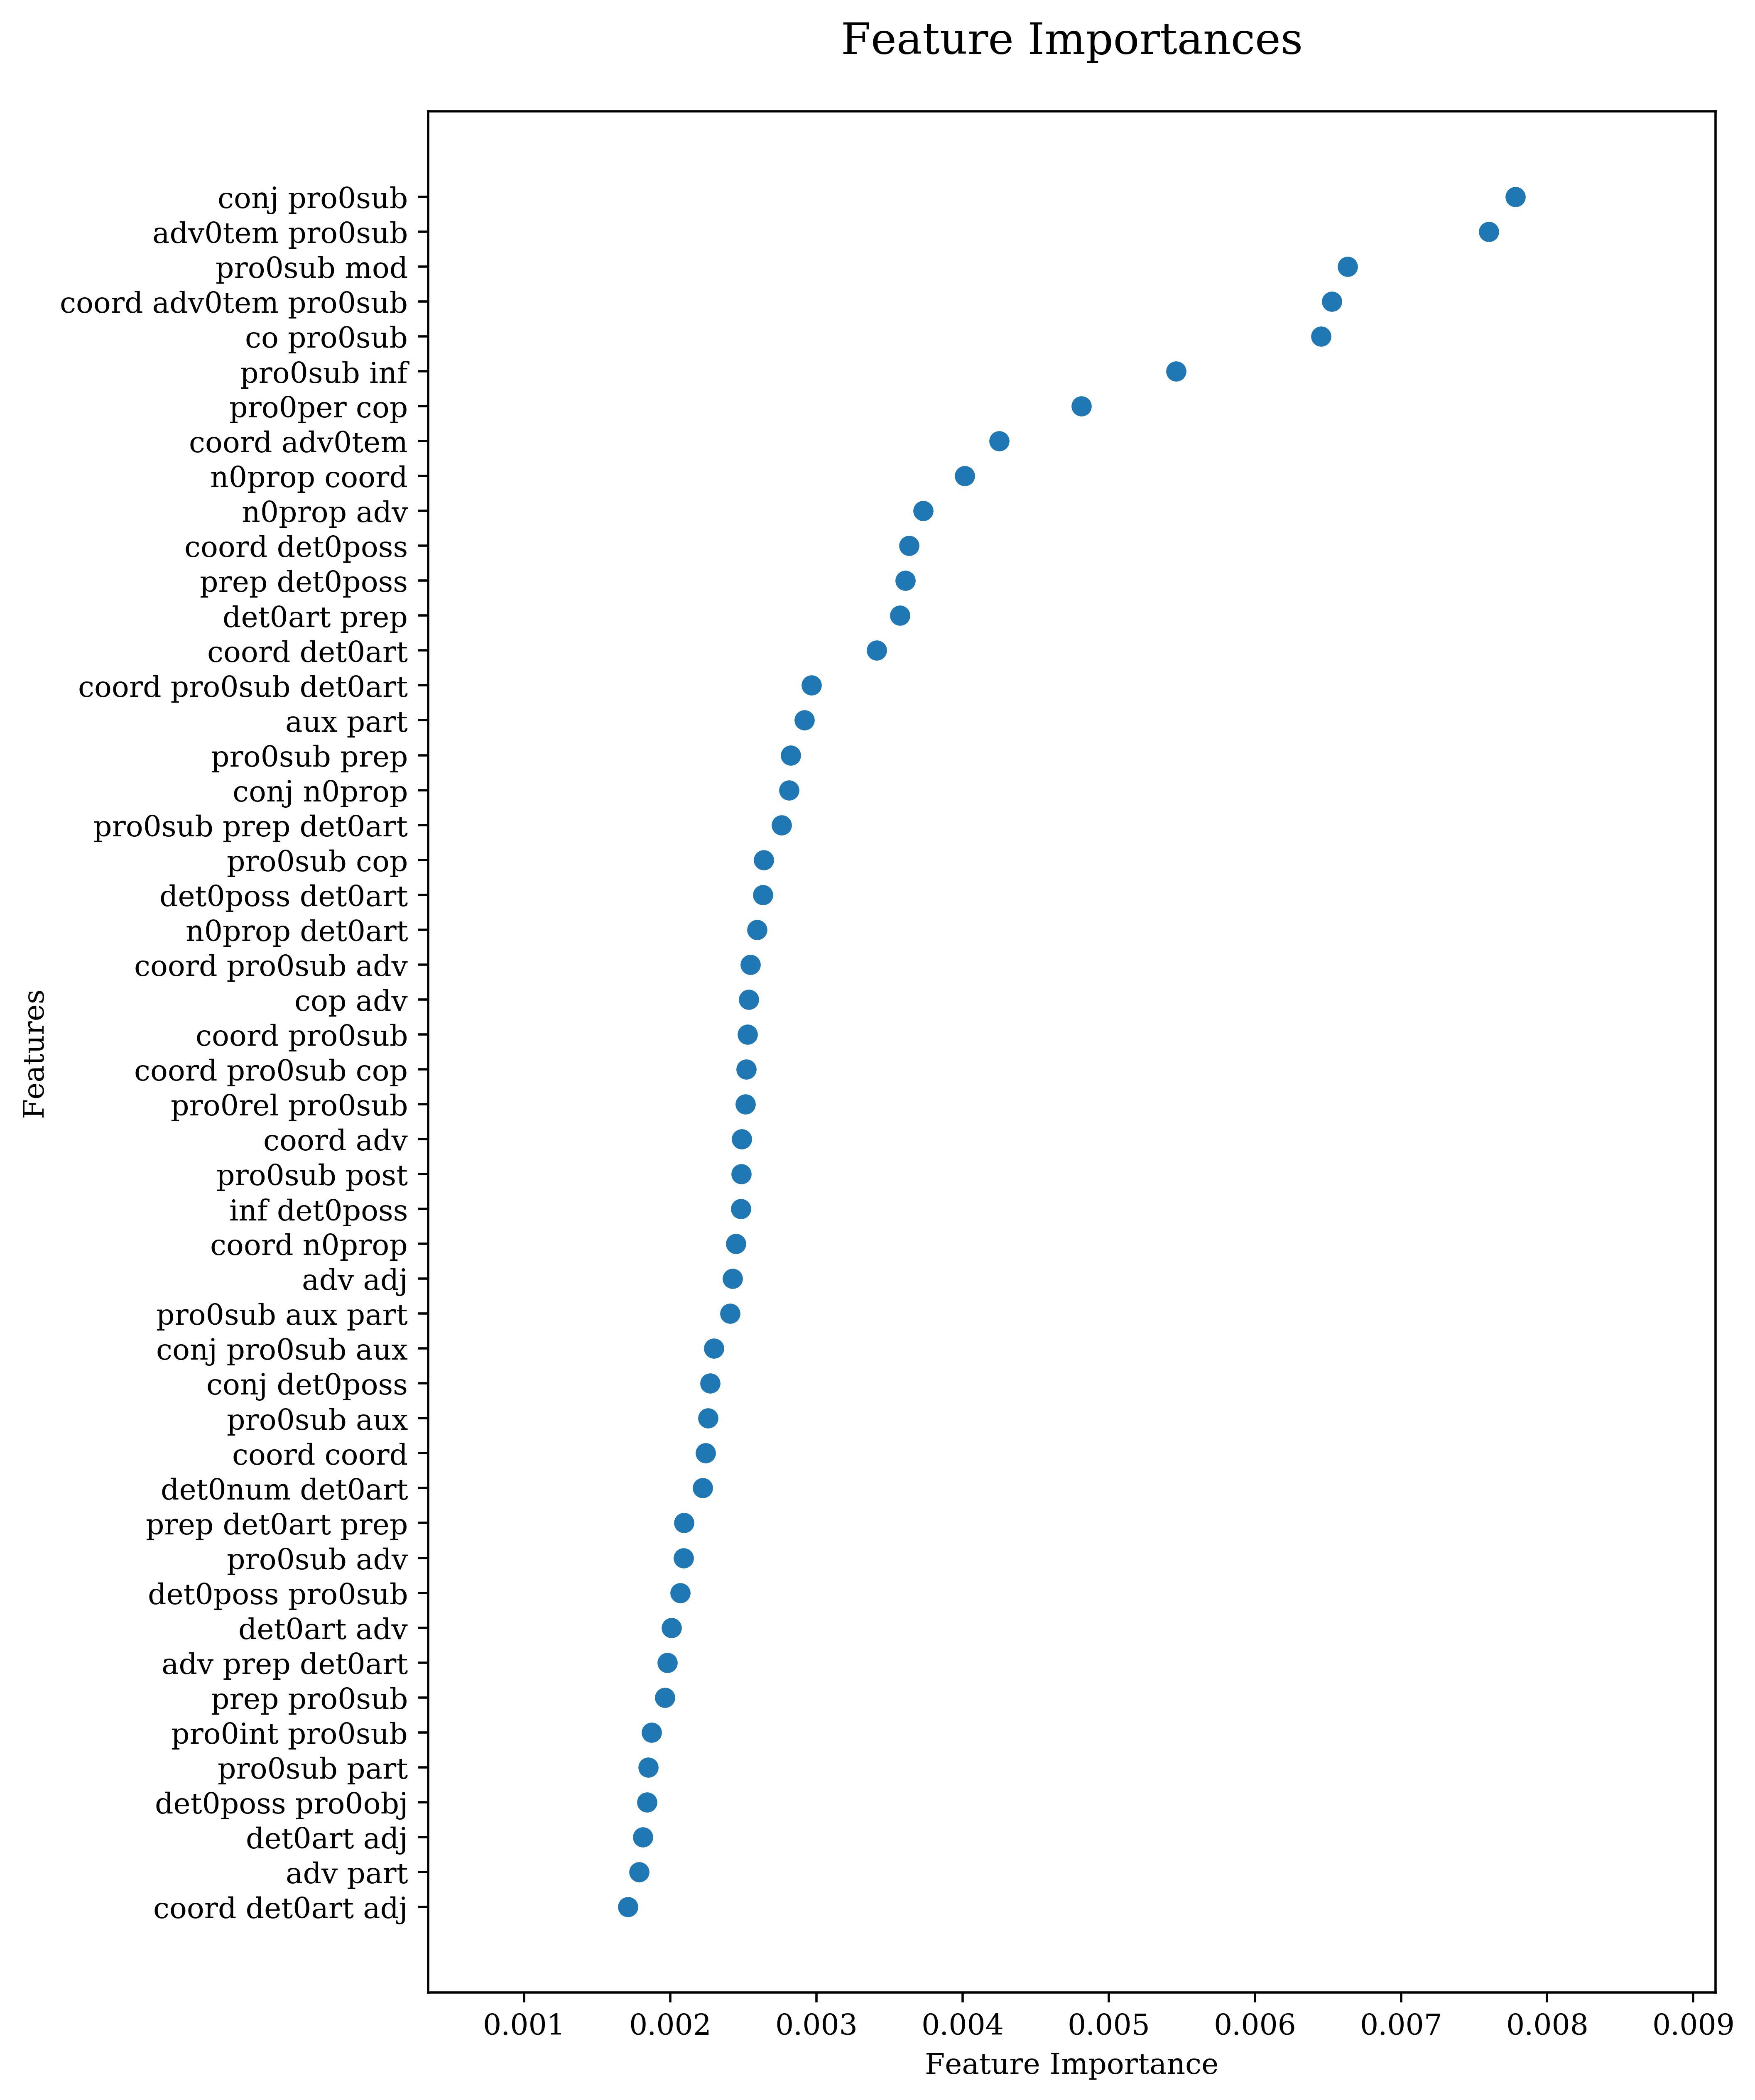

In [37]:
plt.figure(figsize=(8,12), dpi = 500)
plt.scatter(importance[-50:], np.arange(50))
plt.yticks(np.arange(50), features)
plt.title('Feature Importances', fontsize = 15)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
# plt.show()
plt.savefig('plot.png')